In [52]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#LQG Simulation using basic equations for a sliding brick in 1D problem(Double integrator)

In [92]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
Pkg.add("LinearAlgebra")
Pkg.add("PyPlot")
Pkg.add("SparseArrays")
Pkg.add("ControlSystems")
Pkg.add("ForwardDiff")
using LinearAlgebra
using PyPlot
using ForwardDiff
using SparseArrays
using ControlSystems

  Activating project at `~/Documents/Optimal_Control/Sims/LQG`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/LQG/Manifest.toml`


In [93]:
#Discrete Dynamics
h = 0.1  #time step
A = [1 h; 0 1]
B = [0.5*h*h; h]
C = [1.0 0];

In [94]:
#Noise Covariances
W = B*0.1*B'  #Corresponds to white noise force input to dynamics
V = 0.1;  #Noise on position measurements

0.1

In [95]:
n = 2  #number of states
m = 1  #number of controls
Tfinal = 10.0
N = Int(Tfinal/h)+1  #number of time steps
thist = Array(range(0, h*(N-1), step=h));

In [96]:
#LQR cost weights
Q = Array(1.0*I(n))
R = Array(0.1*I(m))
Qn = Q

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [97]:
#Cost function
function J(xhist, uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(size(xhist,2)-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

In [98]:
#Infinite-Horizon LQR Gain and cost-to-go
P = dare(A,B,Q,R)
K = dlqr(A,B,Q,R)

1×2 Matrix{Float64}:
 2.5857  3.44344

In [99]:
#Initial conditions
x0 = [1.0; 0] #true state

#Filter State
∑0 = Array(1.0*I(2))
x̂0 = [0.0; 0.0]

2-element Vector{Float64}:
 0.0
 0.0

In [100]:
xhist = zeros(n,N)
xhist[:,1] .= x0;

uhist = zeros(N)
yhist = zeros(N)
x̂hist = zeros(n,N)
∑hist = zeros(n,n,N);

In [101]:
#Initial Time Step

#Generate Measurement
yhist[1] = (C*xhist[:,1])[1] + sqrt(V)*randn() #randn() samples 0 mean Identity variance gaussian
                                               #sqrt(V)*randn() samples 0 mean V variance gaussian
z = yhist[1] - (C*x̂0)[1]  #Innovation
S = (C*∑0*C')[1] + V  #Innovation Covariance

L = ∑0*C'*inv(S)  #Kalman Gain

x̂hist[:,1] = x̂0 + L*z
∑hist[:,:,1] .= (I-L*C)*∑0*(I-L*C)' + L*V*L'

uhist[1] = -(K*x̂hist[:,1])[1]  #Control input

xhist[:,2] .= A*xhist[:,1] + B*uhist[1] + abs.(sqrt(W))*randn(n)  #Simulate with stochastic dynamics

2-element view(::Matrix{Float64}, :, 2) with eltype Float64:
  0.9883903200485692
 -0.2321935990286113

In [103]:
for k = 2:(N-1)
    
    #Generate Measurement
    yhist[k] = (C*xhist[:,k])[1] + sqrt(V)*randn()
    
    #KF Update
    x̃ = A*x̂hist[:,k-1] + B*uhist[k-1]  #State Prediction
    ∑̃ = A*∑hist[:,:,k-1]*A' + W  #Covariance Prediction
    
    z = yhist[k] - (C*x̃)[1]  #Innovation
    S = (C*∑̃ *C')[1] + V  #Innovation Covariance
    
    L = ∑̃ *C'*inv(S)  #Kalman Gain
    
    x̂hist[:,k] = x̃ + L*z
    ∑hist[:,:,k] = (I-L*C)*∑̃ * (I-L*C)' + L*V*L'
    
    #LQR Controller
    uhist[k] = -(K*x̂hist[:,k])[1]
    
    #Run this on the Stochastic Dynamics
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] + abs.(sqrt(W))*randn(n)
end

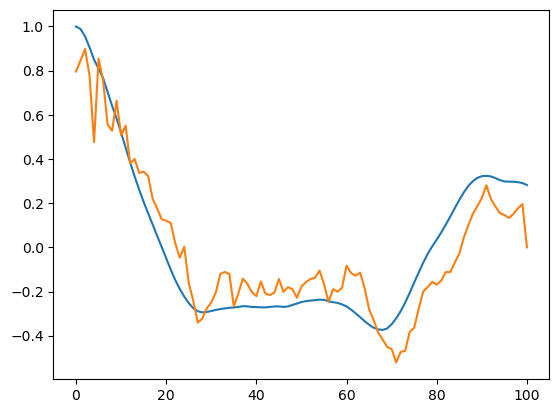

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde1866f130>

In [105]:
plot(xhist[1,:])
plot(x̂hist[1,:])

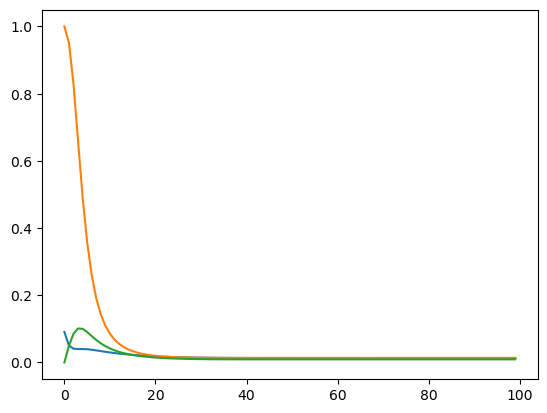

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde185ef370>

In [106]:
#Covariance and Kalman gain covariance to steady-state values in the LTI case
#just like LQR gain + cost-to-go Hessian
plot(∑hist[1,1,1:N-1])
plot(∑hist[2,2,1:N-1])
plot(∑hist[1,2,1:N-1])